# DC casing -- finite wells 

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap
import time
from string import ascii_lowercase

# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import resistivity as dc
from SimPEG import utils, maps, Report
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casing_sim

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 12

In [3]:
# conductivities
sigma_air = 1e-6
sigma_back = 1e-2
sigma_casing = 5e6
sigma_target = 1e-1

# target geometry
target_r = 200
target_z = np.r_[-950, -850]

# casing geometry
casing_b = 5e-2  
casing_t = 10e-3
casing_a = casing_b - casing_t
casing_l = 1000

In [4]:
return_electrode_r = 1000
src_a = np.r_[casing_a+casing_t/2, 0, 0]
src_b = np.r_[return_electrode_r, 0., 0.]

In [5]:
csz = 5
npadz = 12
pf = 1.5

meshes = {}

hx = casing_sim.mesh.pad_for_casing_and_data(
    casing_b,
    csx1=casing_t/4., 
    npadx=6,
    csx2=100,
    domain_x=return_electrode_r
)

# Theta discretization
ny = 12
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

# vertical discretization
ncz = casing_l/csz
hz = discretize.utils.unpack_widths([(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)])

# create the mesh
mesh = discretize.CylindricalMesh([hx, hy, hz], x0=np.r_[0,0,-hz[:-npadz].sum()])
print(mesh.n_cells)

209664


/home/lheagy/.conda/envs/lindsey/lib/python3.8/site-packages/matplotlib/projections/polar.py:48: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


[<PolarAxesSubplot:>, <AxesSubplot:xlabel='x', ylabel='z'>]

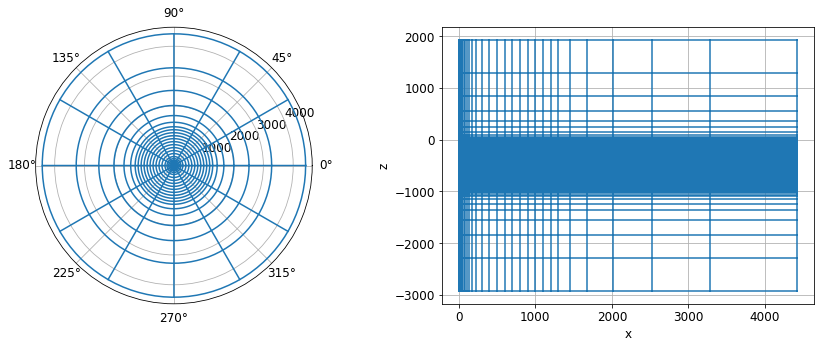

In [6]:
mesh.plot_grid()

In [7]:
inds_casing_x = (
    (mesh.cell_centers[:, 0] > casing_a) & 
    (mesh.cell_centers[:, 0] < casing_b)
)
inds_casing_z = (
    (mesh.cell_centers[:, 2] < 0) &
    (mesh.cell_centers[:, 2] > -casing_l)
)
inds_casing = inds_casing_x & inds_casing_z


inds_target_x = (
    (mesh.cell_centers[:, 0] >= casing_b) &
    (mesh.cell_centers[:, 0] < target_r)
)
inds_target_z = (
    (mesh.cell_centers[:, 2] < target_z.max()) &
    (mesh.cell_centers[:, 2] > target_z.min())
)
inds_target = inds_target_x & inds_target_z

In [8]:
halfspace = sigma_back * np.ones(mesh.n_cells)
halfspace[mesh.cell_centers[:, 2] > 0] = sigma_air

halfspace_target = halfspace.copy()
halfspace_target[inds_target] = sigma_target

casing = halfspace.copy()
casing[inds_casing] = sigma_casing

casing_target = halfspace_target.copy()
casing_target[inds_casing] = sigma_casing

models = {
    "halfspace" : halfspace,
    "halfspace_target" : halfspace_target,
    "casing" : casing,
    "casing_target" : casing_target,
}


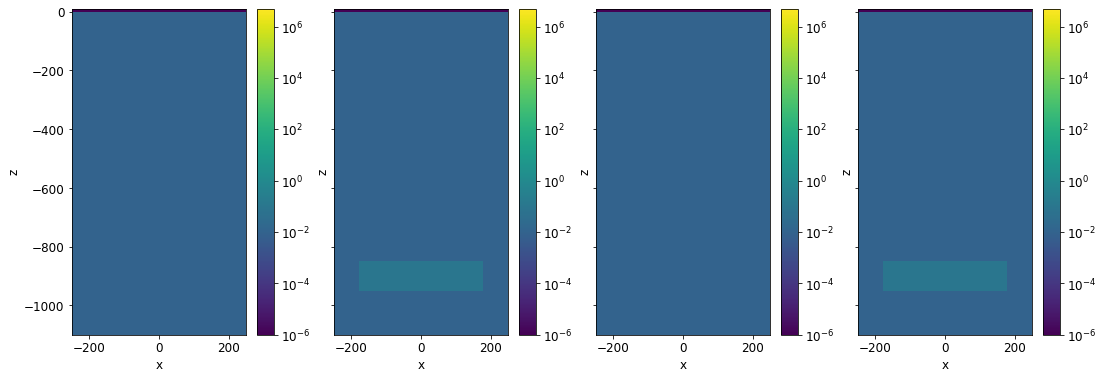

In [9]:
fig, ax = plt.subplots(1, len(models), figsize=(4.5*len(models), 6), sharex=True, sharey=True)

pcolor_opts={"norm":LogNorm(vmin=sigma_air, vmax=sigma_casing)}
for i, key in enumerate(models.keys()):
    casing_sim.view.plot_slice(
        mesh, models[key], pcolorOpts=pcolor_opts, ax=ax[i],
    )
    
    ax[i].set_xlim((target_r+50)*np.r_[-1, 1])
    ax[i].set_ylim(np.r_[-casing_l-100, 10])


## set up the simulations

In [10]:
source = dc.sources.Dipole(location_a=src_a, location_b=src_b)
survey = dc.Survey([source])

simulation = dc.Simulation3DCellCentered(
    mesh=mesh,
    sigmaMap=maps.IdentityMap(mesh),
    solver=Pardiso,
    survey=survey,
    bc_type='Dirichlet'
)

In [11]:
fields = {}
for key, m in models.items():
    t = time.time()
    print(f"starting {key}")
    fields[key] = simulation.fields(m)
    print(f" ... done. {time.time()-t:1.2e} s")

starting halfspace
 ... done. 1.31e+01 s
starting halfspace_target
 ... done. 2.00e+00 s
starting casing
 ... done. 1.84e+00 s
starting casing_target
 ... done. 1.72e+00 s


/home/lheagy/.conda/envs/lindsey/lib/python3.8/site-packages/matplotlib/colors.py:1543: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))
/home/lheagy/git/simpeg/discretize/discretize/mixins/mpl_mod.py:1257: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(
/home/lheagy/.conda/envs/lindsey/lib/python3.8/site-packages/matplotlib/colors.py:1543: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))


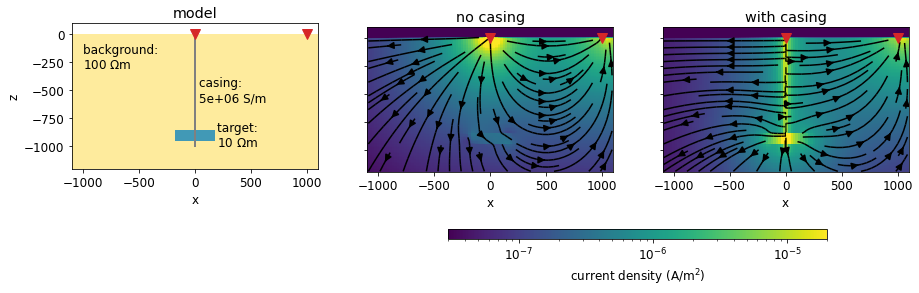

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7), sharex=True, sharey=True)

key="casing_target"
pcolor_opts={"norm":LogNorm(vmin=sigma_back/10, vmax=sigma_target*2), "cmap":"Spectral"}
stream_opts={"color":"k", "density":0.75, "arrowsize":1.4}

xlim = 1100 * np.r_[-1, 1]
zlim = np.r_[-1200, 100]
clim = np.r_[3e-8, 2e-5]

plot_me = models[key].copy()
plot_me[mesh.cell_centers[:, 2] > 0] = np.nan
out = casing_sim.view.plot_slice(
    mesh, plot_me, pcolorOpts=pcolor_opts, ax=ax[0], show_cb=False
)
ax[0].plot(np.r_[0, 0], np.r_[0, -casing_l], color=0.5*np.r_[1, 1, 1], lw=2)
# cb = plt.colorbar(out[0], ax=ax[0], orientation="horizontal", shrink=0.7)
# cb.set_label("conductivity (S/m)")

# annotate
ax[0].text(-1000, -200, f"background: \n{1/sigma_back:1.0f} $\Omega$m", va="center")
ax[0].text(target_r, np.mean(target_z), f"target: \n{1/sigma_target:1.0f} $\Omega$m", va="center")
ax[0].text(40, -500, f"casing: \n{sigma_casing:1.0e} S/m", va="center")
ax[0].set_title("model")

for i, key in enumerate(["halfspace_target", "casing_target"]):
    j=i+1
    f = fields[key]
    ax[j].set_title("")
    
    out = casing_sim.view.plot_cross_section(
        f,
        view="j",
        xlim=xlim,
        zlim=zlim,
        theta_ind=0,
        ax=ax[j], 
        clim=clim,
        show_cb=False if j<3 else True,
        stream_opts=stream_opts
    )
    ax[j].set_ylabel("")

ax[1].set_title("no casing")
ax[2].set_title("with casing")
    
for a in ax:
    a.set_xlim(xlim)
    a.set_ylim(zlim)
    a.plot(np.r_[0, 1000], np.r_[0, 0], "C3v", ms=10)
    a.set_aspect(1)

cb = plt.colorbar(out[0], ax=ax[1:], orientation="horizontal", shrink=0.7, aspect=40)
cb.set_label("current density (A/m$^2$)")

fig.savefig("figures/impact-of-wells", bbox_inches="tight", dpi=200)
fig.savefig("high-rez-figures/impact-of-wells", bbox_inches="tight", dpi=350)


/home/lheagy/git/simpeg/discretize/discretize/mixins/mpl_mod.py:1257: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(
/home/lheagy/git/simpeg/discretize/discretize/mixins/mpl_mod.py:1257: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(


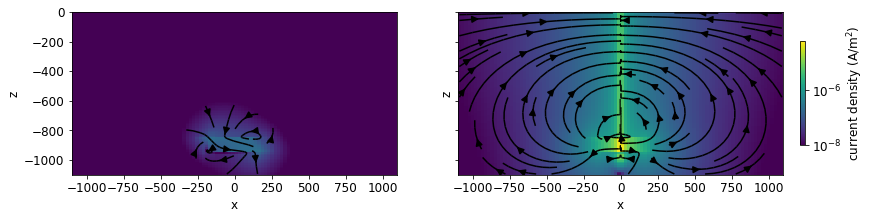

In [13]:
fig, ax = plt.subplots(
    1, 2, 
    figsize=(12, 3),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.07,"wspace":0.1}
)

xlim=1100*np.r_[-1, 1]
zlim=np.r_[-1100, 0]
clim = np.r_[1e-8, 6e-5]



for j, key in enumerate(["halfspace", "casing"]):
    f = fields[f"{key}_target"]
    primary_fields = fields[key]
    ax[j].set_title("")
    
    out = casing_sim.view.plot_cross_section(
        f,
        primary_fields=primary_fields, 
        prim_sec="secondary",
        view="j",
        xlim=xlim,
        zlim=zlim,
        theta_ind=0,
        ax=ax[j], 
        clim=clim,
        show_cb=False if j<3 else True,
        stream_opts=stream_opts
    )
    ax[j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
    ax[j].set_title("")
    ax[j].set_aspect(1)

# ax[0, 0].set_title("half-space")
# ax[0, 1].set_title("casing")

cb = plt.colorbar(out[0], ax=ax[-1], shrink=0.6)
cb.set_label("current density (A/m$^2$)")


In [14]:
from matplotlib import patches

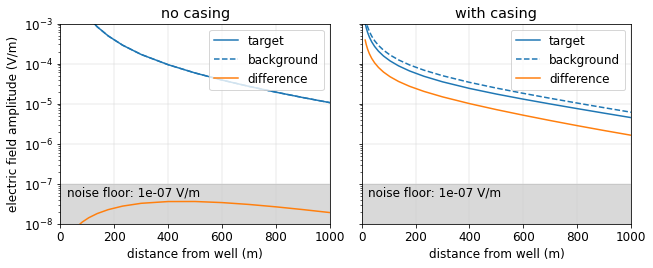

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3.75), sharex=True, sharey=True)

xlim = np.r_[10, 1200]
noise_floor = 1e-7
for i, model_type in enumerate(["halfspace", "casing"]):
    f_plot = [
        fields[f"{model_type}_target"][:,'e'], 
        fields[f"{model_type}"][:,'e'],
        fields[f"{model_type}_target"][:,'e'] - fields[f"{model_type}"][:,'e']
    ]


    for f, c, l, label in zip(
        f_plot, ["C0", "C0", "C1"], ["-", "--" , "-"],
        ["target", "background", "difference"]
    ):
        casing_sim.view.plotLinesFx(
            mesh,
            field=np.absolute(f),
            pltType='semilogy', ax=ax[i], theta_ind=3,
            xlim=xlim,
            color=c, label=label, linestyle=l,
        )
    ax[i].legend(loc=1)
    ax[i].set_xlim(np.r_[0, 1000])
    ax[i].set_ylim(np.r_[1e-8, 1e-3])
    
    patch = patches.Rectangle(
        [0, 1e-9], xlim[1], noise_floor, color='k', alpha=0.15
    )
    ax[i].add_patch(patch)
    ax[i].text(xlim[0]+15, noise_floor*0.9, f"noise floor: {noise_floor:1.0e} V/m", va="top", fontsize=12)

ax[0].set_title("no casing")
ax[1].set_title("with casing")
ax[0].set_ylabel("electric field amplitude (V/m)")

fig.savefig("figures/impact-of-wells-data.png", bbox_inches="tight", dpi=200)
fig.savefig("high-rez-figures/impact-of-wells-data.png", bbox_inches="tight", dpi=350)

/tmp/ipykernel_18085/3396938081.py:8: RuntimeWarning: divide by zero encountered in true_divide
  f = (fields[f"{model_type}_target"][:,'e'] - primary)/primary
/tmp/ipykernel_18085/3396938081.py:8: RuntimeWarning: invalid value encountered in true_divide
  f = (fields[f"{model_type}_target"][:,'e'] - primary)/primary


<AxesSubplot:xlabel='distance from well (m)'>

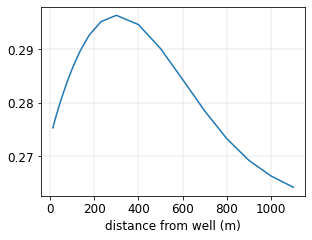

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5), sharex=True, sharey=True)

xlim = np.r_[10, 1200]
noise_floor = 1e-7
model_type="casing"

primary = fields[f"{model_type}"][:,'e']
f = (fields[f"{model_type}_target"][:,'e'] - primary)/primary

casing_sim.view.plotLinesFx(
    mesh,
    field=np.absolute(f),
    pltType='plot', ax=ax, theta_ind=3,
    xlim=xlim,
#     color=c, label=label, linestyle=l,
)


In [17]:
# run an inversion 

